<a href="https://colab.research.google.com/github/asurovi/MSE504_MachineLearning/blob/main/Homework_8_AgnilaGhoshSurovi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 8 (Reinforcement Learning)

**Date:** 10/27/2025

**Name:** Agnila Ghosh Surovi

**Department**: Mechanical and Aerospace Engineering (MAE)

# Problem Statement:

Using the 3x4 grid world notebook from the course GitHub, explore the effect of the reward for a step and slipping probability on the policies.
- Start with the exploration of the reward for a step - e.g. generate policies using the simple grid search and then cluster policies. The exploration in the joint (reward, slipping probability) space can in principle be done by grid, but this will take quite a while.
- Suggest alternative strategies for exploration based on reasonable assumptions (e.g. you can try to take a list of policies from the 1D experiment and
- check if they are optimal for specific reward, slipping probability case). The output should be list of policies, their distribution in 1D space, and policy map in the 2D paramter space.

The course 3x4 Gridworld is used with wall at (1,1), terminals +1 (0,3) and -1 (1,3), discount $\gamma$ =0.99. Actions may slip: intended move with probability $(1-p_{\text{slip}})$, perpendicular left/right with $(p_{\text{slip}}/2)$. Nonterminal steps yield reward $(r_{\text{step}})$; terminals give ±1.

For each parameter setting, the optimal deterministic policy is solved via policy iteration.

* In 1D experiment, $(r_{\text{step}})$ is varied at fixed $(p_{\text{slip}}=0.20)$;
* Policies are clustered by identity (same action at every nonterminal state and same policy_id).
* In 2D experiment, a grid is sweeped over ($r_{\text{step}}$, $p_{\text{slip}}$), reusing the 1D policy catalog.

# Answer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np, random
np.random.seed(0)        # makes tie-breaking reproducible
random.seed(0)


In [ ]:
try:
    n_rows
except NameError:
    n_rows, n_cols = 3, 4
    wall = (1,1)
    terminal_rewards = {(0,3): +1.0, (1,3): -1.0}
    ACTIONS = ['U','D','L','R']
    DELTA   = {'U':(-1,0),'D':(1,0),'L':(0,-1),'R':(0,1)}

def _in_bounds(rc):
    r,c = rc
    return 0 <= r < n_rows and 0 <= c < n_cols and (r,c) != wall

def _step_probs(s, a, slip, r_step):
    if s in terminal_rewards:
        return [(1.0, s, terminal_rewards[s], True)]
    r,c = s
    if a=='U': intended, slips = 'U', ['L','R']
    elif a=='D': intended, slips = 'D', ['R','L']
    elif a=='L': intended, slips = 'L', ['D','U']
    else:       intended, slips = 'R', ['U','D']
    outcomes = [(1-slip, intended), (slip/2, slips[0]), (slip/2, slips[1])]
    res = []
    for p, aa in outcomes:
        dr,dc = DELTA[aa]
        nr,nc = r+dr, c+dc
        if not _in_bounds((nr,nc)): nr,nc = r,c
        ns = (nr,nc)
        if ns in terminal_rewards:
            res.append((p, ns, terminal_rewards[ns], True))
        else:
            res.append((p, ns, r_step, False))
    return res

def _fallback_policy_iteration(gamma, slip, r_step, tol=1e-9, itmax=10000):
    states = [(r,c) for r in range(n_rows) for c in range(n_cols) if (r,c)!=wall]
    pi = {}
    for s in states:
        pi[s] = None if s in terminal_rewards else np.random.randint(4)

    def _eval(pi):
        V = {s:0.0 for s in states}
        for _ in range(itmax):
            delta = 0.0
            for s in states:
                if s in terminal_rewards:
                    vnew = terminal_rewards[s]
                else:
                    a = ACTIONS[pi[s]]
                    trans = _step_probs(s, a, slip, r_step)
                    vnew = sum(p*(r + (0 if done else gamma*V[ns])) for p,ns,r,done in trans)
                delta = max(delta, abs(vnew - V[s]))
                V[s] = vnew
            if delta < tol: break
        return V

    for _ in range(200):
        V = _eval(pi)
        stable = True
        for s in states:
            if s in terminal_rewards: continue
            qs=[]
            for a in ACTIONS:
                trans = _step_probs(s, a, slip, r_step)
                q = sum(p*(r + (0 if done else gamma*V[ns])) for p,ns,r,done in trans)
                qs.append(q)
            best = int(np.argmax(qs))
            if best != pi[s]: stable = False
            pi[s] = best
        if stable: break
    return pi  # state -> action index

# ---- Render & clustering helpers ----
ACTIONS = ['U','D','L','R']
arrow = {'U':'↑','D':'↓','L':'←','R':'→'}

def render_policy_grid(policy, n_rows=3, n_cols=4, wall=(1,1), terminals={(0,3):+1,(1,3):-1}):
    grid = []
    for r in range(n_rows):
        row=[]
        for c in range(n_cols):
            s=(r,c)
            if s==wall: row.append('#')
            elif s in terminals: row.append('+1' if terminals[s]>0 else '-1')
            else:
                a_idx = policy[s]
                a = ACTIONS[a_idx] if isinstance(a_idx,int) else a_idx
                row.append(arrow[a])
        grid.append(' '.join(f'{x:>2}' for x in row))
    return '\n'.join(grid)

def policy_key(policy, n_rows=3, n_cols=4, wall=(1,1), terminals={(0,3):+1,(1,3):-1}):
    order = [(r,c) for r in range(n_rows) for c in range(n_cols)
             if (r,c)!=wall and (r,c) not in terminals]
    return tuple(policy[s] for s in order)

def solve_optimal_policy(slip, step_reward, gamma=0.99):
    try:
        env.slip = slip                # CHANGE HERE if your env uses a different name
        env.step_reward = step_reward  # CHANGE HERE if your env uses a different name
    except Exception:
        globals()['SLIP_PROB']  = slip
        globals()['STEP_REWARD'] = step_reward

    if 'policy_iteration' in globals():
        try:
            policy, _ = policy_iteration(env, gamma=gamma)
            return policy
        except TypeError:
            policy, _ = policy_iteration(gamma=gamma, slip=slip, r_step=step_reward)
            return policy
        except Exception:
            pass
    if 'value_iteration' in globals():
        try:
            out = value_iteration(env, gamma=gamma)
        except TypeError:
            out = value_iteration(gamma=gamma)
        return out[1] if isinstance(out, tuple) and len(out)==2 else out
    # Fallback
    return _fallback_policy_iteration(gamma=gamma, slip=slip, r_step=step_reward)


,r_step,slip,policy_id
0,0.0000,0.2,0
1,-0.0025,0.2,0
2,-0.0050,0.2,0
3,-0.0100,0.2,0
4,-0.0200,0.2,1
5,-0.0300,0.2,1
6,-0.0400,0.2,2
7,-0.0600,0.2,2
8,-0.0800,0.2,3
9,-0.1000,0.2,3


,policy_id,policy_grid
0,0,→ → → +1\n ↑ # ← -1\n ↑ ← ← ↓
1,1,→ → → +1\n ↑ # ↑ -1\n ↑ ← ← ←
2,2,→ → → +1\n ↑ # ↑ -1\n ↑ ← ↑ ←
3,3,→ → → +1\n ↑ # ↑ -1\n ↑ → ↑ ←
4,4,→ → → +1\n ↑ # ↑ -1\n ↑ → ↑ ↑


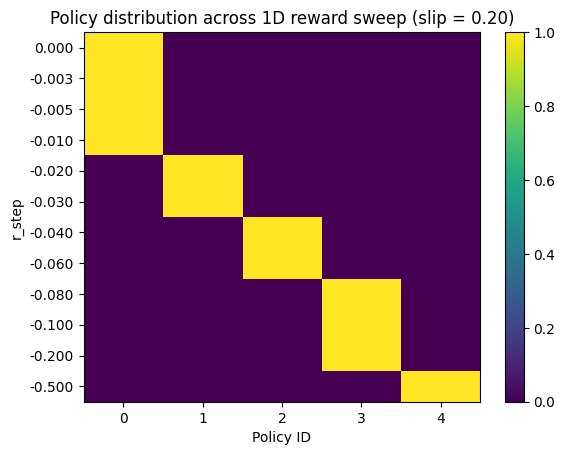

In [ ]:
# ===========================
# 1D EXPLORATION OF STEP REWARD
# ===========================
# Sweep different step reward (r_step) values at a fixed slip probability (0.20).
# For each reward value, compute the optimal policy using policy iteration.
# Then assign a unique policy_id for each distinct policy (same actions => same id).
# Finally, visualize how policy identity changes as r_step becomes more negative.

gamma = 0.99
slip_fixed = 0.20
r_values = [0.0,-0.0025,-0.005,-0.01,-0.02,-0.03,-0.04,-0.06,-0.08,-0.10,-0.20,-0.50]

pid_map, unique_policies, pid_counter = {}, {}, 0
rows_1d = []

for r_step in r_values:
    pi = solve_optimal_policy(slip_fixed, r_step, gamma=gamma)
    key = policy_key(pi)
    if key not in pid_map:
        pid_map[key] = pid_counter
        unique_policies[pid_counter] = pi
        pid_counter += 1
    rows_1d.append({'r_step': r_step, 'slip': slip_fixed, 'policy_id': pid_map[key]})

df1 = pd.DataFrame(rows_1d)
display(df1)

df_policies_1d = pd.DataFrame(
    [{'policy_id': pid, 'policy_grid': render_policy_grid(pi)} for pid, pi in sorted(unique_policies.items())]
).sort_values('policy_id').reset_index(drop=True)
display(df_policies_1d)

# 1D distribution heatmap
counts = df1.groupby('r_step')['policy_id'].apply(list).apply(lambda xs: Counter(xs))
policy_ids_sorted = sorted(set(df1['policy_id']))
mat = np.zeros((len(r_values), len(policy_ids_sorted)), dtype=int)
for i, rv in enumerate(r_values):
    cnt = counts.loc[rv] if rv in counts.index else Counter()
    for j, pid in enumerate(policy_ids_sorted):
        mat[i,j] = cnt.get(pid, 0)

plt.imshow(mat, aspect='auto')
plt.xticks(range(len(policy_ids_sorted)), policy_ids_sorted)
plt.yticks(range(len(r_values)), [f"{v:.3f}" for v in r_values])
plt.xlabel("Policy ID"); plt.ylabel("r_step")
plt.title("Policy distribution across 1D reward sweep (slip = 0.20)")
plt.colorbar(); plt.show()

# Optional: save artifacts
df1.to_csv('oneD_policy_distribution.csv', index=False)
df_policies_1d.to_csv('unique_policies_1d.csv', index=False)


,r_step,slip,policy_id
0,0.0,0.00,3
1,0.0,0.05,1
2,0.0,0.10,1
3,0.0,0.15,0
4,0.0,0.20,0
...,...,...,...
65,-0.2,0.10,3
66,-0.2,0.15,3
67,-0.2,0.20,3
68,-0.2,0.25,3


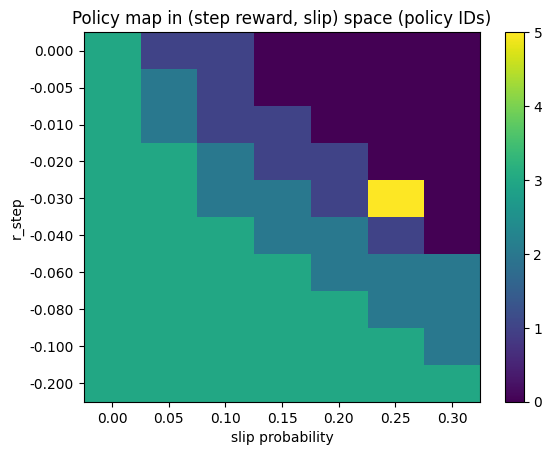

,policy_id,policy_grid
0,0,→ → → +1\n ↑ # ← -1\n ↑ ← ← ↓
1,1,→ → → +1\n ↑ # ↑ -1\n ↑ ← ← ←
2,2,→ → → +1\n ↑ # ↑ -1\n ↑ ← ↑ ←
3,3,→ → → +1\n ↑ # ↑ -1\n ↑ → ↑ ←
4,4,→ → → +1\n ↑ # ↑ -1\n ↑ → ↑ ↑
5,5,→ → → +1\n ↑ # ← -1\n ↑ ← ← ←


In [ ]:
# ===========================
# 2D EXPLORATION OF (STEP REWARD, SLIP PROBABILITY)
# ===========================
# For each pair (r_step, slip), compute the optimal policy.
# Store the resulting policy_id in a 2D grid to visualize
# how policy changes across both parameters.

r_grid    = [0.0,-0.005,-0.01,-0.02,-0.03,-0.04,-0.06,-0.08,-0.10,-0.20]
slip_grid = [0.00,0.05,0.10,0.15,0.20,0.25,0.30]

policy_map = np.full((len(r_grid), len(slip_grid)), -1, dtype=int)

for i, r_step in enumerate(r_grid):
    for j, slip in enumerate(slip_grid):
        pi = solve_optimal_policy(slip, r_step, gamma=gamma)
        key = policy_key(pi)
        if key not in pid_map:
            pid_map[key] = pid_counter
            unique_policies[pid_counter] = pi
            pid_counter += 1
        policy_map[i,j] = pid_map[key]

df2 = pd.DataFrame(
    [{'r_step': r_grid[i], 'slip': slip_grid[j], 'policy_id': int(policy_map[i,j])}
     for i in range(len(r_grid)) for j in range(len(slip_grid))]
)
display(df2)

plt.imshow(policy_map, aspect='auto')
plt.xticks(range(len(slip_grid)), [f"{p:.2f}" for p in slip_grid])
plt.yticks(range(len(r_grid)),  [f"{r:.3f}" for r in r_grid])
plt.xlabel("slip probability"); plt.ylabel("r_step")
plt.title("Policy map in (step reward, slip) space (policy IDs)")
plt.colorbar(); plt.show()

# Optional: save artifacts
df2.to_csv('policy_map_2d.csv', index=False)

# Also print the full unique policy catalog discovered
df_policies_all = pd.DataFrame(
    [{'policy_id': pid, 'policy_grid': render_policy_grid(pi)} for pid, pi in sorted(unique_policies.items())]
).sort_values('policy_id').reset_index(drop=True)
display(df_policies_all)


## Results:

- 1D (slip=0.20): As $r_{\text{step}}$ becomes more negative, the optimal policy shifts through a small set of archetypes: 0 -> 2 -> 3 -> 4. This reflects increasing impatience—shorter routes dominate; for very harsh penalties the agent may terminate at -1 to avoid further step costs.

- 2D map: Increasing slip makes the policy risk-averse, steering away from the -1 corridor (safer top-row routes). Increasing step penalties favors shorter horizons. The parameter plane decomposes into distinct policy regions with clear boundaries; a small island (policy 5) appears where routes are nearly tied.

- Alternative exploration (faster than dense 2D):
  1. Policy reuse—evaluate the 1D catalog policies at new $(r, p_{\text{slip}}$ and pick the best; optionally 1-2 improvement steps.
  2. Adaptive region-growing—solve a coarse grid, refine where policies differ.
  3. Warm starts—carry over $V, \pi$ to neighboring cells.
  4. Boundary tracing—classify $(r, p)$ based on policy_id and sample near uncertain boundary regions.